### 라이브러리

In [1]:
import sys, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml

### 함수 정의

In [2]:
# 활성화함수 식 자체 정의

def sigmoid(x):
    return 1 / (1+np.exp(-x))

def softmax(x):
    if x.ndim == 2: # 배치일 때
        x = x.T
        x = x - np.max(x, axis=0) # 오버플로 방지
        y = np.exp(x)/ np.sum(np.exp(x), axis=0)
        return y.T
    
    x = x - np.max(x)
    return np.exp(x) / np.sum(np.exp(x), axis=0)


# 활성화함수 정의

class Sigmoid:
    def __init__(self):
        self.out = None
        
    def forward(self, x):
        self.out = sigmoid(x)
        return self.out
    
    def backward(self, dout):
        dx = dout * (1.0 - self.out) * self.out
        return dx

class Relu:
    def __init__(self):
        self.mask = None
    
    def forward(self, x):
        # relu 활성화 함수 특징
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] = 0
        return out
        
    def backward(self, dout):
        dout[self.mask] = 0
        dx = dout
        return dx

In [3]:
# 손실함수 정의

def mean_squared_error(y, y_hat):
    return 0.5 * np.sum((y-y_hat)**2)

def cross_entropy_error(y, y_hat):
    if y.ndim == 1: # 벡터일 때
        y = y.reshape(1, y.size) # 원 핫 인코딩
        y_hat = y_hat.reshape(1, y_hat.size)
        
    if y.size == y_hat.size: # 원 핫 인코딩일 때
        y_hat = y_hat.argmax(axis=1)
        
    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), y_hat] + 1e-7)) / batch_size

In [4]:
# Affine층 정의

class Affine:
    def __init__(self, W, b):
        self.W = W
        self.b = b
        
        self.x = None
        self.original_x_shape = None
        
        # 가중치와 편향 매개변수의 미분
        self.dW = None
        self.db = None
    
    def forward(self, x):
        # 텐서 변환
        self.original_x_shape = x.shape
        self.x = x.reshape(x.shape[0], -1)
        
        out = np.dot(self.x, self.W) + self.b
        return out
    
    def backward(self, dout):
        # 계산 그래프 이용하여 미분식 수립
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis=0)
        
        dx = dx.reshape(*self.original_x_shape)
        return dx
    

class SoftmaxWithLoss:
    def __init__(self):
        self.loss = None # 손실함수
        self.y = None # softmax의 출력
        self.t = None # 정답 레이블(원 핫 인코딩 형태)
        
    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy_error(self.y, self.t)
        return self.loss
    
    def backward(self, dout=1): # 역전파 처음 들어오는 미분값은 1로 지정
        batch_size = self.t.shape[0]
        
        if self.t.size == self.y.size: # 원 핫 인코딩 형태가 동일하면
            dx = (self.y - self.t) / batch_size
        else:
            dx = self.y.copy()
            dx[np.arange(batch_size), self.t] -= 1
            dx = dx / batch_size
        return dx
            

In [5]:
# 기울기(미분) 업데이트 정의

def numerical_gradient(f, x):
    h = 1e-4 # 0.0001
    grad = np.zeros_like(x) # 미분에 대한 자리 먼저 형성
    
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        idx = it.multi_index
        tmp_val = x[idx]
        x[idx] = float(tmp_val) + h
        fxh1 = f(x) # f(x+h)
        
        x[idx] = tmp_val - h
        fxh2 = f(x) # f(x-h)
        
        grad[idx] = (fxh1 - fxh2) / (2*h) # 미분 구하기
        x[idx] = tmp_val # 값 복원
        
        it.iternext()
    return grad

In [6]:
# DNN 구조 설계
class Custom_TwoLayerNet:
    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
        # 가중치 초기화
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)
        
        # 계층 생성
        self.layers = {}
        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
        self.layers['Relu1'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])
        
        # 마지막 계층
        self.lastLayer = SoftmaxWithLoss()
      
    # 예측
    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        return x
    
    # x: 입력 데이터, t: 정답 레이블, y: 예측 레이블
    def loss(self, x, t):
        y_hat = self.predict(x)
        return self.lastLayer.forward(y_hat, t)
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if t.ndim != 1: t = np.argmax(t, axis=1)
        
        accuracy = np.sum(y==t) / float(x.shape[0])
        return accuracy
    
    # 수치미분
    def numerical_gradient(self, x, t): # x: 입력 데이터, t: 정답 레이블
        loss_W = lambda W: self.loss(x, t)
        
        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        
        return grads
    
    # 역전파
    def gradient(self, x, t):
        # forward
        self.loss(x, t)
        
        # backward
        dout = 1
        dout = self.lastLayer.backward(dout)
        
        layers = list(self.layers.values())
        layers.reverse() # 역전파는 뒤어서부터 계산되니 순서를 역으로
        for layer in layers:
            dout = layer.backward(dout)
        
        # 결과 저장
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Affine1'].dW, self.layers['Affine1'].db 
        grads['W2'], grads['b2'] = self.layers['Affine2'].dW, self.layers['Affine2'].db
        
        return grads

---

### 메인 코드

In [7]:
# 데이터 수집
mnist = fetch_openml('mnist_784')
x, y = mnist.data, mnist.target
print(x.shape, y.shape)

(70000, 784) (70000,)


In [8]:
# 학습 및 검증 데이터 준비
y = pd.get_dummies(y) # 원 핫 인코딩 형태로 변환

x_train, y_train = np.array(x[:60000]), np.array(y[:60000])
x_test, y_test = np.array(x[60000:]), np.array(y[60000:])

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(60000, 784) (60000, 10) (10000, 784) (10000, 10)


In [9]:
# 모델 생성
network = Custom_TwoLayerNet(input_size=x_train.shape[1], hidden_size=50, output_size=y_train.shape[1])

In [10]:
# 하이퍼 파라미터 지정
iters_num = 10000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)

In [11]:
# 학습 진행
for i in range(iters_num):
    
    # batch size만큼 뽑기
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    y_batch = y_train[batch_mask]
    
    # 기울기 계산
    grad = network.gradient(x_batch, y_batch) # 오차역전법 방식(수치미분보다 훨씬 빠르다.)
    
    # 갱신
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]
    
    
    # 학습 현황(loss, accuracy) 저장
    loss = network.loss(x_batch, y_batch)
    train_loss_list.append(loss)
    
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, y_train)
        test_acc = network.accuracy(x_test, y_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print(f'train_acc:{train_acc}, test_acc:{test_acc}')

print('complete...')

train_acc:0.09966666666666667, test_acc:0.1016
train_acc:0.11236666666666667, test_acc:0.1135
train_acc:0.11236666666666667, test_acc:0.1135
train_acc:0.11236666666666667, test_acc:0.1135
train_acc:0.11236666666666667, test_acc:0.1135
train_acc:0.11236666666666667, test_acc:0.1135
train_acc:0.11236666666666667, test_acc:0.1135
train_acc:0.11236666666666667, test_acc:0.1135
train_acc:0.11236666666666667, test_acc:0.1135
train_acc:0.11236666666666667, test_acc:0.1135
train_acc:0.10218333333333333, test_acc:0.101
train_acc:0.11236666666666667, test_acc:0.1135
train_acc:0.11236666666666667, test_acc:0.1135
train_acc:0.11236666666666667, test_acc:0.1135
train_acc:0.11236666666666667, test_acc:0.1135
train_acc:0.11236666666666667, test_acc:0.1135
train_acc:0.11236666666666667, test_acc:0.1135
complete...


Text(0.5, 1.0, 'test_acc')

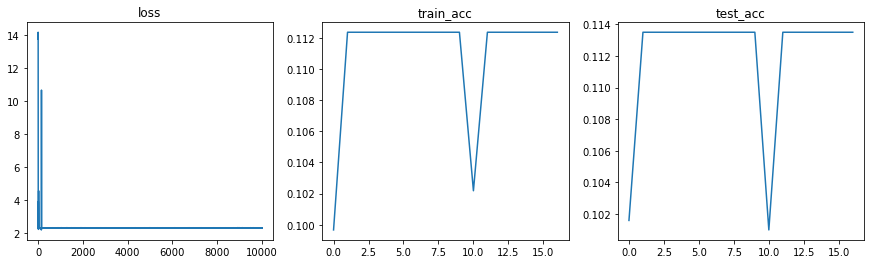

In [12]:
# 그래프로 학습 결과 확인
plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
plt.plot(train_loss_list)
plt.title('loss')

plt.subplot(1, 3, 2)
plt.plot(train_acc_list)
plt.title('train_acc')

plt.subplot(1, 3, 3)
plt.plot(test_acc_list)
plt.title('test_acc')